# Лабараторная работа 1
Вариант 11

#### **Цель работы:**
Научиться реализовывать один из алгоритмов глубокого обучения.

#### **Задание:**
1. Скачайте датасет [CarDatasets](https://drive.google.com/drive/folders/1pkudEBabqbXMxRTgfGQs3e0VqfTjtqWU)
2. Реализуйте ResNet-101 с оптимизатором [Adabound](https://arxiv.org/abs/1902.09843v1) с использованием
Numpy и с **Torch**/Tensorflow/Jax
3. Оцените качество модели на тесте и сравните быстродействие
реализованных вариантов.
4. Запустить обучение на классическом Adam и сравнить сходимость
результатов с вариантом задания.
5. Сделайте отчёт в виде readme на GitHub, там же должен быть выложен
исходный код.

#### **Отчёт должен содержать следующие пункты:**
1. Теоретическая база
2. Описание разработанной системы (алгоритмы, принципы работы,
архитектура)
3. Результаты работы и тестирования системы (скриншоты, изображения,
графики, закономерности)
4. Выводы по работе
5. Использованные источники

План:
1. Получить Dataloader, возвращающий обрезанное в соответствии с annotations изображение, убедиться, что тензор корректно конвертируется в numpy
2. Загрузить и запустить готовый resnet101. Хотя, скорее всего, это не пригодится. Запустить на нём обучение
3. Имплементировать на torch
4. Имплементирвать на numpy


* Resnet обязательно 224x224?
* Обязательно квадратные картинки?
* Лучше машина целиком в низком разрешении и мб сжатая по горизонтали или фрагмент машины?
* Rgb или gray-scale?


В датасете есть одноканальные изображения

In [2]:
import os
from collections import Counter


import scipy.io
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score


# from pytorch_implementations.resnet import resnet101

In [3]:
torchvision.datasets.StanfordCars('.', split = "train", download = True)
torchvision.datasets.StanfordCars('.', split = "test", download = True)

Dataset StanfordCars
    Number of datapoints: 8041
    Root location: .

In [ ]:
"""
try:
    from google.colab import drive
    IN_COLAB = True
    drive.mount('/content/drive')
except:
    IN_COLAB = False
"""

In [ ]:

# class ResizeToNeededHeight(torch.nn.Module):
    
#     def __init__(self, needed_height, interpolation=torchvision.transforms.InterpolationMode.BILINEAR, max_size=None, antialias=None):
#         super().__init__()
#         #_log_api_usage_once(self)
        
#         self.needed_height = needed_height
#         self.max_size = max_size

#         self.interpolation = interpolation
#         self.antialias = antialias

#     def forward(self, img):
#         """
#         Args:
#             img (PIL Image or Tensor): Image to be scaled.
#         Returns:
#             PIL Image or Tensor: Rescaled image.
#         """
#         w, h = img.size
#         size = (self.needed_height, round(w / h * self.needed_height))
#         return torchvision.transforms.functional.resize(
#             img, size, self.interpolation, self.max_size, self.antialias)

#     def __repr__(self) -> str:
#         detail = f"(needed_height={self.needed_height}, interpolation={self.interpolation.value}, max_size={self.max_size}, antialias={self.antialias})"
#         return f"{self.__class__.__name__}{detail}"


In [ ]:
"""
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
"""

In [4]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, annotations, classes = None, img_folder_path = '',
                 transform=None, target_transform=None):
        
        self.annotations = annotations
        self.transform = transform
        self.target_transform = target_transform
        self.img_folder_path = img_folder_path
        self.classes = classes

    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, idx):
        x1, y1, x2, y2, class_number, img_name = self.annotations[idx]
        uncropped_image = torchvision.io.read_image(
            os.path.join(self.img_folder_path, img_name))
        image = uncropped_image[:, y1:y2, x1:x2]
        #image = image.to(dtype = torch.float32)
        if image.shape[-3] == 1:
            image = torch.cat([image, image, image], dim=0)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            class_number = self.target_transform(class_number)
        return image, class_number - 1 # В аннтоациях числа от 1 до 196
    
# class CarsDatasetWithoutLabels(CarsDataset):
#     def __getitem__(self, idx):
#         x1, y1, x2, y2, img_name = self.annotations[idx]
#         uncropped_image = torchvision.io.read_image(
#             os.path.join(self.img_folder_path, img_name))
#         image = uncropped_image[:, y1:y2, x1:x2]
#         # image = image.to(dtype = torch.float32)
#         if self.transform:
#             image = self.transform(image)
#         return image


In [5]:

#if IN_COLAB:
#    dataset_loc = r"/content/drive/MyDrive/LR1-1"
#else:
#    dataset_loc = r"C:\Users\SystemPoint\Downloads\LR1-1"


dataset_loc = r"./stanford_cars"

# annos['train'] и annos['val'] содержат x1, y1, x2, y2, class, img_name для каждого изображения датасета.
# class_names по индексу, равному числовому лейблу возвращает соответствующее имя класса
annos = dict()
annos['train'] = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_train_annos.mat'),
    squeeze_me = True
)['annotations']
annos['val'] = scipy.io.loadmat(
    os.path.join(dataset_loc, 'cars_test_annos_withlabels.mat'),
    squeeze_me = True
)['annotations']


class_names = scipy.io.loadmat(
    os.path.join(r"./stanford_cars/devkit", 'cars_meta.mat'),
    squeeze_me = True
)['class_names']

normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = dict()
data_transforms['train'] = (
    torchvision.transforms.Compose([
        # AddGaussianNoise(0.0,0.0000001),
        torchvision.transforms.ToPILImage(),
        #ResizeToNeededHeight(180),
        torchvision.transforms.RandomRotation((-13, 13)), # if you do rotation afterwords the quality will be worse
        torchvision.transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        torchvision.transforms.RandomHorizontalFlip(p = 0.5),
        # torchvision.transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))

data_transforms['val'] = (
    torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        # torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.Resize((96, 96)),
        #ResizeToNeededHeight(180),
        #torchvision.transforms.RandomCrop(224, pad_if_needed=True),
        torchvision.transforms.Grayscale(num_output_channels=1),
        torchvision.transforms.ToTensor(),
        # normalize
    ]))


folder_names = {
    "train": 'cars_train',
    "val": 'cars_test'
}


datasets = {
    phase: CarsDataset(annos[phase], img_folder_path = os.path.join(dataset_loc, folder_names[phase]), 
                       transform = data_transforms[phase], classes = class_names)
    for phase in ['train', 'val']
}



dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=400,# 512 - много
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'val':
    torch.utils.data.DataLoader(datasets['val'],
                                batch_size=400,
                                shuffle=False,
                                num_workers=0),  # for Kaggle
}

In [6]:
len(datasets['train']), len(datasets['val'])

(8144, 8041)

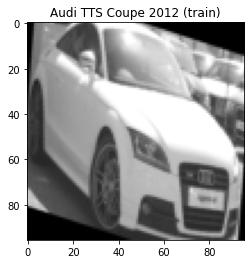

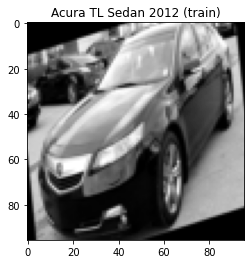

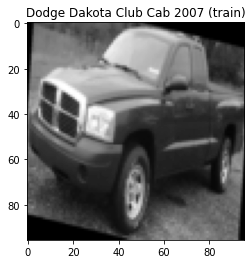

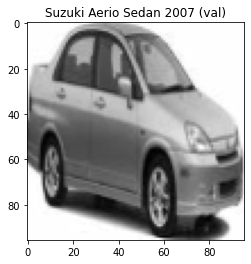

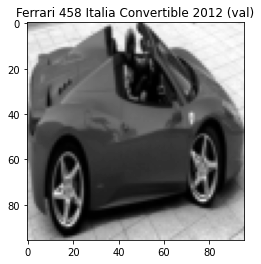

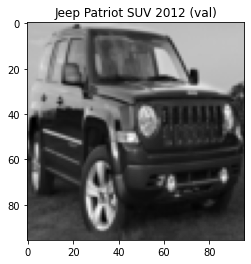

In [7]:
for phase in ['train', 'val']:
    for i in range(3):
        image, class_number = datasets[phase][i]
        plt.imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        plt.title(datasets[phase].classes[class_number]+ f' ({phase})')
        plt.show()

In [ ]:
# min_h = 10000
# indexes_less_than_3_channels = []
# for i, (tensor, label) in enumerate(dataset_with_labels):
#     c, h, w = tensor.shape
#     min_h = min(h, min_h)
#     if c < 3:
#         indexes_less_than_3_channels.append(i)
#         if c != 1:
#             print(f"unexpected_number_of_channels: {c}")
# print(f"min_h = {min_h}")
# print(indexes_less_than_3_channels)

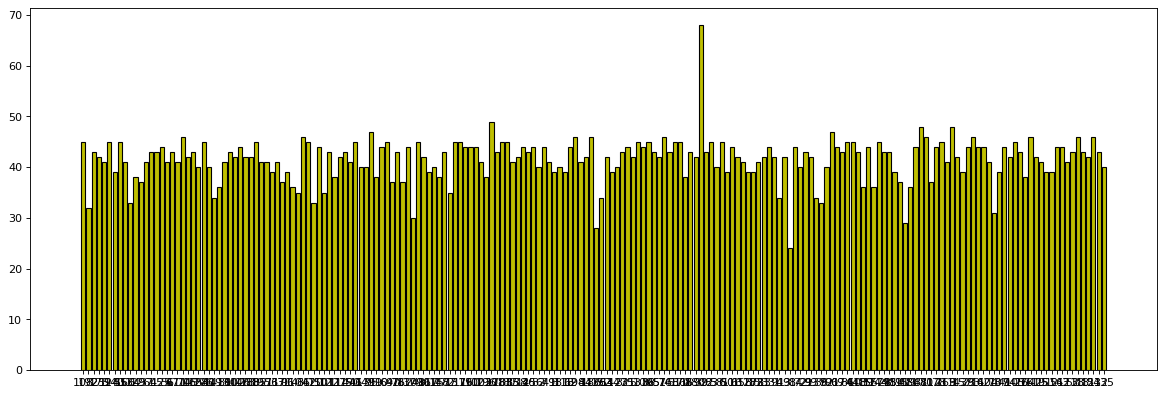

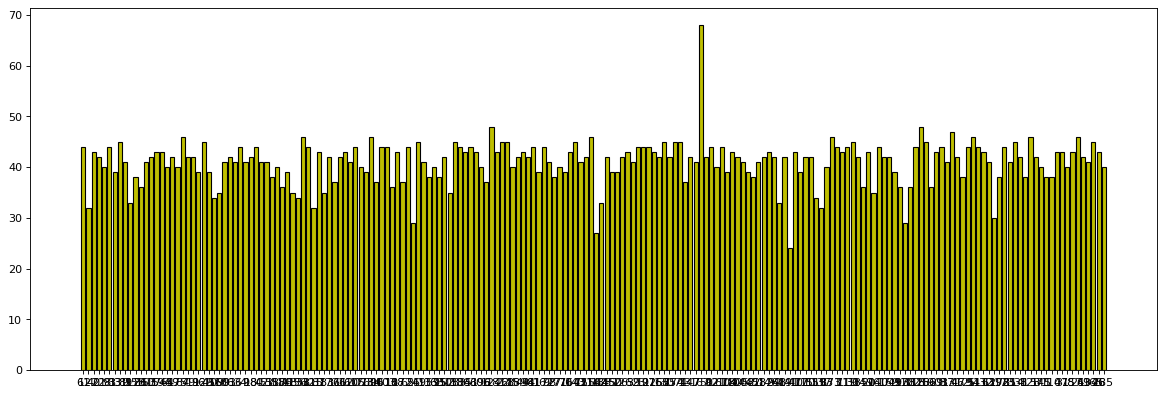

In [8]:
from collections import Counter

classes_train = [line[4] for line in annos['train']]
classes_val = [line[4] for line in annos['val']]

train_classes_count_dict = dict(Counter(classes_train))
val_classes_count_dict = dict(Counter(classes_val))
    
    
for value_counts in [train_classes_count_dict, val_classes_count_dict]:
    plt.figure(figsize=(40, 6), dpi=80)

    plt.subplot(1, 2, 1)
    plt.bar(
        x = value_counts.keys(),
        height = value_counts.values(),
        width = 0.8,
        align = 'center',
        color='y',
        edgecolor='k',
        tick_label=list(range(1, 197)),
        label = list(datasets['val'].classes))

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
n_classes = len(datasets['train'].classes)
n_classes

196

In [11]:
def train_model(model, criterion, optimizer, num_epochs=3, history = None):
    test_loss_history = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
    
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')
            
            if history is not None:
                history[phase]["f_score"].append(epoch_f_score)
                history[phase]["loss"].append(epoch_loss)
                history[phase]["accuracy"].append(epoch_acc)

            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [ ]:
transfer_resnet = torchvision.models.resnet18(pretrained=True)
    
for param in transfer_resnet.parameters():
    param.requires_grad = False   
    
transfer_resnet.fc = torch.nn.Sequential(
               torch.nn.Linear(transfer_resnet.fc.in_features, 200),
               torch.nn.ReLU(inplace=True),
               torch.nn.Linear(200, n_classes))

transfer_resnet = transfer_resnet.to(device)

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(transfer_resnet.fc.parameters(), lr = 0.01)

In [ ]:
history = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

In [ ]:
transfer_resnet.load_state_dict(torch.load(r"../input/resnet-18-200-fc-40-epochesh5/resnet_18_200_fc_40_epoches.h5"))

In [ ]:
train_model(transfer_resnet, criterion, optimizer, num_epochs = 10, history = history)

In [ ]:
model = transfer_resnet
train_loader = dataloaders['train']
test_loader = dataloaders['val']

In [ ]:
n_epochs = 1

# compare overfited
train_loss_data,valid_loss_data = [],[]

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    all_true_labels = []
    all_preds = []
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in train_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() #*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in test_loader:
        # Move input and label tensors to the default device
        data, target = data.to(device), target.to(device)
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item() #*data.size(0)
        # convert output probabilities to predicted class
        _, pred = torch.max(output, 1)
        # compare predictions to true label
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        all_true_labels.extend(target.tolist())
        all_preds.extend(pred.tolist())
        

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(test_loader.dataset)
    
    #clculate train loss and running loss
    train_loss_data.append(train_loss)
    valid_loss_data.append(valid_loss)
    
    print('Epoch: {}/{} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1,
        n_epochs,
        train_loss,
        valid_loss
        ))
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('\t\tValidation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        # torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

In [ ]:
f1_score(all_true_labels, all_preds, average = 'macro')

In [ ]:
sum(a==b for a,b in zip(all_true_labels, all_preds))/len(all_true_labels)

In [ ]:
all_true_labels[:10]

In [ ]:
all_preds[:10]

In [ ]:
weights_name = 'transfer_resnet18_200fc.h5'
# weights_loc = os.path.join('.','pytorch_implementations','weights')
weights_loc = '.'
weights_path = os.path.join(weights_loc, weights_name)

torch.save(transfer_resnet.state_dict(), weights_path)

In [ ]:
!nvidia-smi


In [23]:
from typing import List

import torch  # Used only for flattening
import torch.nn as nn
from torch import Tensor  # For typing

__all__ = ['ResNet', 'resnet101', 'Bottleneck']  # ! Bottleneck is temporary here

def conv3x3(in_channels: int, out_channels: int, stride: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding (to reserve feature map size)"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)

def conv1x1(in_channels: int, out_channels: int, stride: int = 1) -> nn.Conv2d:
    return nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False)

class Bottleneck(nn.Module):
    """
    A "bottleneck" building block of a ResNet.
    This block always consists of a sequence of three convolutions:
    1x1, 3x3, 1x1. For example if out_channels = 64, then the sequence is
    [
        1x1, 64
        3x3, 64
        1x1, 256
    ]

    Attributes:
        in_channels: The number of input channels of the first convolution.
        bottleneck_depth: The number of output channels (for the first two convolutions).
        stride_for_downsampling: The stride for downsampling the input.
    """

    # The number of output channels for the last convolution is always 4 times
    # more than for than for other convolutions. 
    expansion: int = 4

    def __init__(
        self,
        in_channels: int,
        bottleneck_depth: int,
        stride_for_downsampling: int = 1,
    ) -> None:
        super().__init__()
        self.in_channels = in_channels
        self.bottleneck_depth = bottleneck_depth
        self.stride_for_downsampling = stride_for_downsampling

        self.conv1 = conv1x1(in_channels, bottleneck_depth, stride_for_downsampling)
        self.conv2 = conv3x3(bottleneck_depth, bottleneck_depth)
        self.conv3 = conv1x1(bottleneck_depth, bottleneck_depth * self.expansion)
        self.relu = nn.ReLU(inplace=True)

        # There are two cases for performing a convolution on identity:
        # 1. There will be downsampling (stride_for_downsampling != 1)
        # 2. The number of bottleneck's output channels is different from the
        #    number of input channels (in_channels != bottleneck_depth * self.expansion)
        # Note that the number of input's channels is equal to the number
        # of output's channels when it's not the first bottleneck in a block. 
        self.conv_to_match_dimensions = None
        if in_channels != bottleneck_depth * self.expansion or stride_for_downsampling != 1:
            self.conv_to_match_dimensions = conv1x1(in_channels, bottleneck_depth * self.expansion, stride_for_downsampling)
        # ! Возможно, стоит вынести проверку на необходимость применения conv_to_match_dimensions
        # отсюда в ResNet и передавать в Bottleneck параметр need_to_match_dimensions
    
    def forward(self, x: Tensor) -> Tensor:

        if self.conv_to_match_dimensions:
            identity = self.conv_to_match_dimensions(x)
        else:
            identity = x

        out = self.conv1(x)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.relu(out)

        out = self.conv3(out)

        out += identity
        out = self.relu(out)

        return out

class ResNet(nn.Module):
    """
    ResNet model.

    Attributes:
        block (nn.Module): Building block type. Currently Bottleneck only.
        block_nums: Number of blocks for each block configuration.
            For example for ResNet-50, n_blocks = [3, 4, 6, 3].
        n_classes (int): Number of classes.
        img_channels (int): Number of channels in the input image.

    """

    def __init__(
        self,
        block: nn.Module,
        block_nums: List[int],
        n_classes: int,
        img_channels: int = 3,
    ) -> None:
        super().__init__()
        self.cur_block_in_channels = 64
        self.conv1 = nn.Conv2d(
            img_channels, self.cur_block_in_channels,
            kernel_size=7, stride=2, padding=3, bias=False)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2_x = self._make_blocks(block_nums[0], 64, False)
        self.conv3_x = self._make_blocks(block_nums[1], 128)
        self.conv4_x = self._make_blocks(block_nums[2], 256)
        self.conv5_x = self._make_blocks(block_nums[3], 512)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, n_classes)

    def _make_blocks(
        self,
        n_blocks: int,
        bottleneck_depth: int,
        downsampling: bool = True
    ) -> nn.Sequential:
        """
        Creates a sequence of blocks for a specific stage of ResNet.
        Args:
            n_blocks (int): Number of blocks in the stage.
            first_block_in_channels (int): Number of input channels for the first block.
            downsampling (bool): Whether to downsample the feature map.
                If True, the feature map is downsampled by a factor of 2
                in the first convolution of the first block. downsampling is
                supposed to be True for conv3_x, conv4_x, conv5_x, and False
                for conv2_x.
        Returns:
            nn.Sequential: A sequence of blocks. For example
                all blocks of conv_1_x.
        """
        
        blocks = []
        stride_for_downsampling = 2 if downsampling else 1
        block = Bottleneck(self.cur_block_in_channels, bottleneck_depth, stride_for_downsampling)
        self.cur_block_in_channels = bottleneck_depth * block.expansion
        blocks.append(block)
        for i in range(1, n_blocks):
            block = Bottleneck(self.cur_block_in_channels, bottleneck_depth)
            blocks.append(block)
        return nn.Sequential(*blocks)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.conv2_x(x)
        x = self.conv3_x(x)
        x = self.conv4_x(x)
        x = self.conv5_x(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet101(n_classes: int, img_channels: int) -> ResNet:
    return ResNet(Bottleneck, [3, 4, 23, 3], n_classes, img_channels)

In [13]:
my_resnet101 = resnet101(n_classes, 1).to(device)

In [14]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(my_resnet101.fc.parameters(), lr = 0.05)
# lr = 0.01 для начала гораздо лучше, чем 0.001
# 0.05 > 0.01 > 0.001

In [15]:
optimizer1 = torch.optim.Adam(my_resnet101.fc.parameters(), lr = 0.075)

In [21]:
def train_model(model, criterion, optimizer, num_epochs=3, phases = ['train', 'val'], history = None):
    test_loss_history = []
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)
    
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0
            all_true_labels = []
            all_preds = []
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_true_labels.extend(labels.tolist())
                all_preds.extend(preds.tolist())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.item() / len(datasets[phase])
            epoch_f_score = f1_score(all_true_labels, all_preds, average = 'macro')
            
            if history is not None:
                history[phase]["f_score"].append(epoch_f_score)
                history[phase]["loss"].append(epoch_loss)
                history[phase]["accuracy"].append(epoch_acc)

            # print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}")
            print(f"{phase} loss: {epoch_loss:.4f}, f_score: {epoch_f_score:.4f}, accuracy: {epoch_acc}")

In [17]:
my_resnet_history = {
    "train": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    },
    "val": {
        "loss": [],
        "f_score": [],
        "accuracy": [],
    }
} 

In [24]:
my_resnet101.load_state_dict(torch.load(r"/kaggle/working/my_resnet_64_gray_history_20_epoches.h5"))

<All keys matched successfully>

In [ ]:
n_train_epoches_in_iter = 4
for i in range(6):
    print(i)
    print("----------")
    train_model(my_resnet101, criterion, optimizer1, num_epochs=n_train_epoches_in_iter, phases = ['train'], history = my_resnet_history)
    
    weights_name = f'my_resnet101_06_01_2023_without_batch_norm_96x96_black_and_whiten__epoch_{48+(i+1)*n_train_epoches_in_iter}.h5'
    # weights_loc = os.path.join('.','pytorch_implementations','weights')
    weights_loc = '.'
    weights_path = os.path.join(weights_loc, weights_name)
    torch.save(my_resnet101.state_dict(), weights_path)
    
    train_model(my_resnet101, criterion, optimizer1, num_epochs=1, phases = ['val'], history = my_resnet_history)
    

0
----------
Epoch 1/4
----------


100%|██████████| 21/21 [03:04<00:00,  8.79s/it]


train loss: 5.2416, f_score: 0.0076, accuracy: 0.01362966601178782
Epoch 2/4
----------


100%|██████████| 21/21 [02:57<00:00,  8.46s/it]


train loss: 5.2442, f_score: 0.0085, accuracy: 0.013998035363457761
Epoch 3/4
----------


100%|██████████| 21/21 [02:56<00:00,  8.42s/it]


train loss: 5.2420, f_score: 0.0072, accuracy: 0.013015717092337918
Epoch 4/4
----------


100%|██████████| 21/21 [02:57<00:00,  8.45s/it]


train loss: 5.2429, f_score: 0.0081, accuracy: 0.014734774066797643
Epoch 1/1
----------


100%|██████████| 21/21 [01:39<00:00,  4.75s/it]


val loss: 5.2956, f_score: 0.0027, accuracy: 0.011565725656012934
1
----------
Epoch 1/4
----------


100%|██████████| 21/21 [02:57<00:00,  8.46s/it]


train loss: 5.2197, f_score: 0.0093, accuracy: 0.014489194499017682
Epoch 2/4
----------


100%|██████████| 21/21 [03:00<00:00,  8.59s/it]


train loss: 5.2246, f_score: 0.0090, accuracy: 0.015594302554027505
Epoch 3/4
----------


100%|██████████| 21/21 [03:00<00:00,  8.60s/it]


train loss: 5.2279, f_score: 0.0101, accuracy: 0.016453831041257368
Epoch 4/4
----------


100%|██████████| 21/21 [01:41<00:00,  4.83s/it]


val loss: 5.2516, f_score: 0.0052, accuracy: 0.013804253202338017
2
----------
Epoch 1/4
----------


100%|██████████| 21/21 [03:00<00:00,  8.58s/it]


train loss: 5.2264, f_score: 0.0098, accuracy: 0.016576620825147347
Epoch 2/4
----------


 57%|█████▋    | 12/21 [01:45<01:17,  8.61s/it]

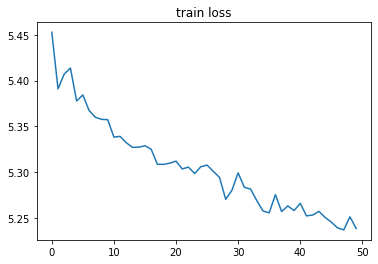

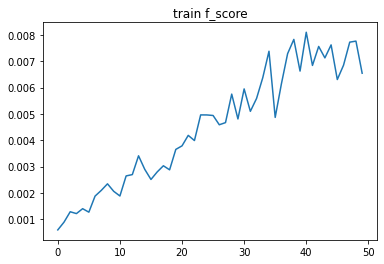

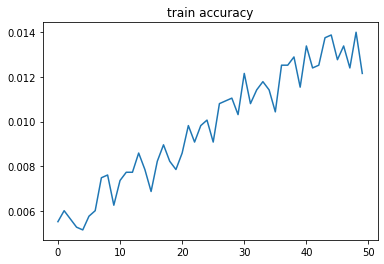

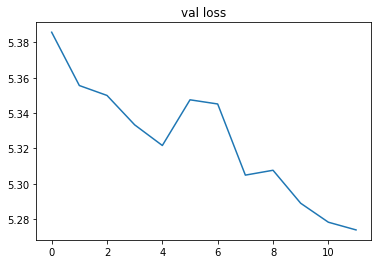

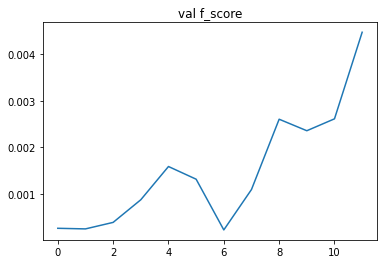

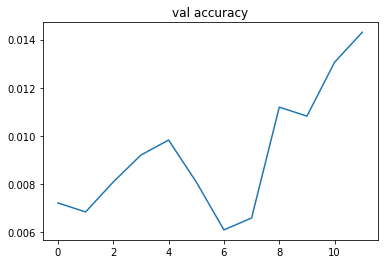

In [7]:
for phase in ['train', 'val']:
    for key, value in my_resnet_history[phase].items():
        plt.plot(value)
        plt.title(f"{phase} {key}")
        plt.show()


In [ ]:
weights_name = 'my_resnet101_withoutnorm_96x96_55_epoches_imagenet_norm.h5'
# weights_loc = os.path.join('.','pytorch_implementations','weights')
weights_loc = '.'
weights_path = os.path.join(weights_loc, weights_name)

torch.save(my_resnet101.state_dict(), weights_path)